## Import Images

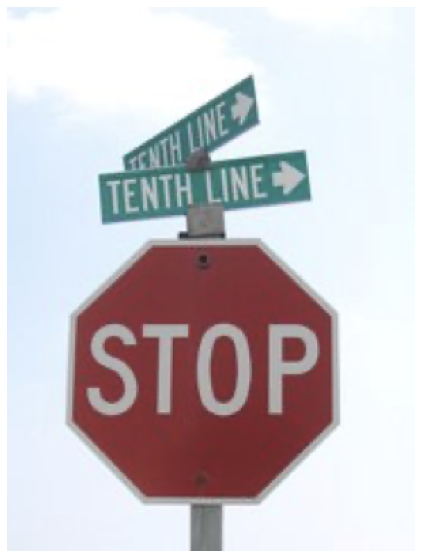

In [3]:
#!/bin/python3

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

def importImage(name):
    return cv.imread('../dataset/images/' + name, cv.IMREAD_COLOR)

def importImageDataset(no):
    return importImage('road' + str(no) + '.png')


# Displays image if grayscale or colored
def displayImage(image, title=""):
    if (len(image.shape) == 3):
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        cmap = None
    else:
        cmap = "gray"
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

displayImage(importImageDataset(52))

## Export CSV

In [4]:
import xml.etree.ElementTree as ET

df = pd.DataFrame(columns=["type"])

for i in range(0, 877):
    with open(f"../dataset/annotations/road{i}.xml") as xml:
        tree = ET.parse(xml)
        root = tree.getroot()
        
        objects = root.findall("object")
        types = []
        for object in objects:
            types.append(object.find("name").text)

        df.loc[i] = ([types])

df.to_csv("../dataset/signs.csv", index=False)

## Import CSV

In [5]:
signs = pd.read_csv("../dataset/signs.csv")

def typeToList(x):
    x["type"] = x["type"].replace("[", "")
    x["type"] = x["type"].replace("]", "")
    x["type"] = x["type"].replace("'", "")
    x["type"] = x["type"].strip()
    x["type"] = x["type"].split(", ")
    return x["type"]

signs["type"] = signs.apply(typeToList, axis=1)

def filterType(types):
    # Types needs to be a list
    def filter(x):
        return len(set(x["type"]) & set(types)) != 0

    return signs[signs.apply(filter, axis=1) == True]

filterType(["speedlimit"])

,type
100,[speedlimit]
101,[speedlimit]
102,[speedlimit]
103,[speedlimit]
104,[speedlimit]
...,...
871,[speedlimit]
872,"[speedlimit, stop]"
873,"[speedlimit, speedlimit, stop]"
874,"[speedlimit, speedlimit, stop]"


Load Image

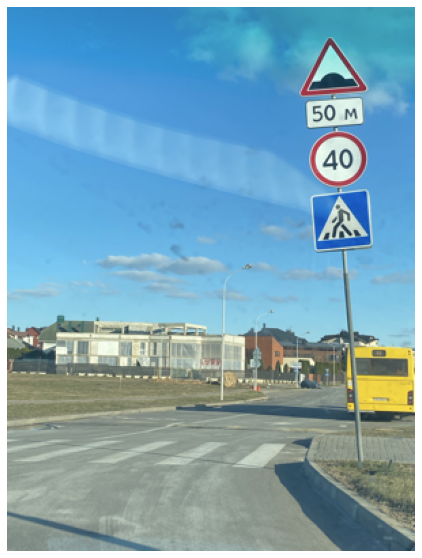

In [6]:
imgId = filterType(["stop"]).index[2]
imgId = 578
img = importImageDataset(imgId)
# To see the pipeline process with a custom image, load an image to the img variable like commented bellow
#img = cv.imread('custom_image_path')
displayImage(img)

## Image Preprocessing
Apply clahe to enhance saturation and value

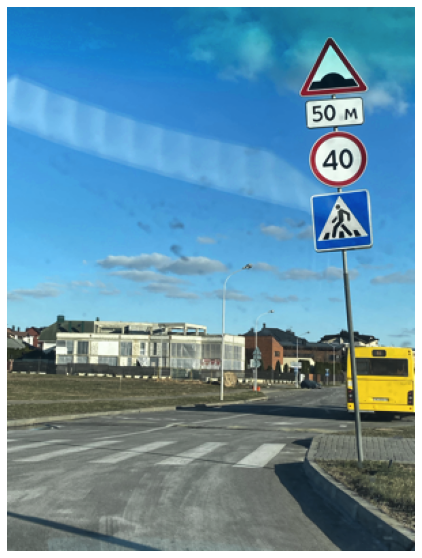

In [7]:
def applyCLAHE(img):
    clahe = cv.createCLAHE(clipLimit=1.0, tileGridSize=(1,1))
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h,s,v = cv.split(hsv)
    s = clahe.apply(s)
    v = clahe.apply(v)
    img = cv.merge([h, s, v])
    img = cv.cvtColor(img, cv.COLOR_HSV2BGR)

    return img

img = applyCLAHE(img)
displayImage(img)

### Mean Shift
Used to unify most colors

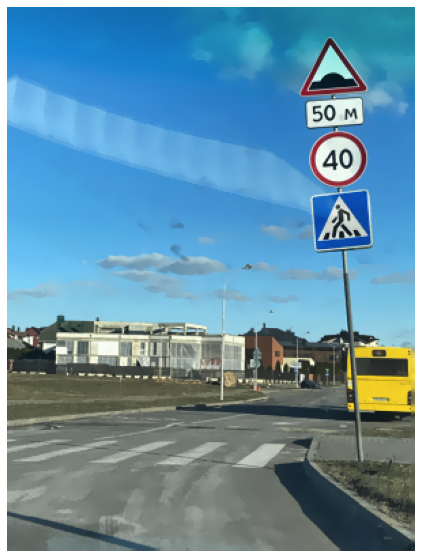

In [8]:
def meanShift(img):
    return cv.pyrMeanShiftFiltering(img, 3, 15, 50)

img = meanShift(img)
displayImage(img)

## Segmentação em áreas de interesse
This section tries to delimit areas of interest to analyze. These areas correspond to regions where traffic signs are located. For this, the HSV colorspace will be used to filter the colors of interest: **blue** and **red**

### Blue, Red and Saturation score approach
Assigns redness and blueness scores, depending on the distance of the color to the blue and red colors, to the image. This makes it so that, for example, blue-greenish colors aren't filtered out from the image.  
A saturation measurement sd assigns a value to the pixels' saturation. It will be used to differentiate blue and red regions that have higher saturation values.

In [9]:
def calcScoreRedBlueScore(B, G, R, S):
    R /= 255
    G /= 255
    B /= 255
    TH1, TH2 = 0.40/3, 0.7 / 3
    DIFF_TH_B = 50 / 255
    DIFF_TH_R = 36 / 255
    c_max = max(R, G, B)
    c_min = min(R, G, B)

    if (c_max == B and (c_max - c_min) >= DIFF_TH_B):
        hd_blue = 1 - abs(R - G) / (c_max - c_min)
    else:
        hd_blue = 0

    if (c_max == R and (c_max - c_min) >= DIFF_TH_R):
        hd_red = 1 - abs(G - B) / (c_max - c_min)
    else:
        hd_red = 0
    from math import e
    sd = e ** -(((S - 255) ** 2) / (115 ** 2))

    hs = max(hd_blue, hd_red) * min(sd, 1)
    if hs < TH1:
        hs = 0
    elif TH1 <= hs < TH2:
        hs = ((hs - TH1)) / (TH2 - TH1)
    else:
        hs = 1

    return hd_blue * 255, hd_red * 255, hs * 255

### Shadow and Highlight Invariant Algorithm
Find regions that are close to values that within the desired hue range using flooding algorithms

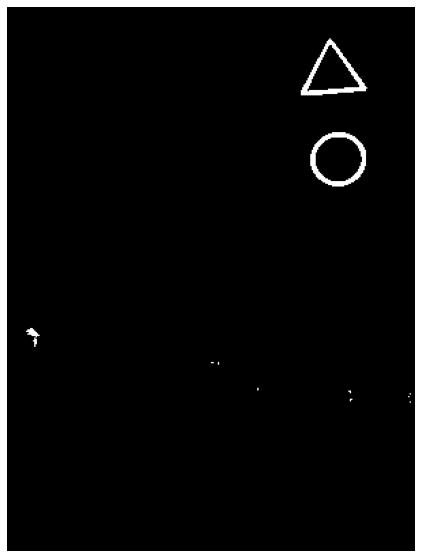

In [10]:
RED = 0
BLUE = 1


def splitColorShadowHighlightInv(img, color):
    def calcScore(H, S, V):
        H = H * 255 / 179
        if color == RED:
            if (H > 210 and H <= 255) or (H >= 0 and H < 10):
                H = 255
            else: 
                H = 0
        elif color == BLUE:
            if (H > 150 and H <= 175):
                H = 255
            else:
                H = 0

        if S < 40:
            H = 0

        if V < 30 or V > 230:
            H = 0

        return H


    height, width = img.shape[0], img.shape[1]
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    b, g, r = cv.split(img)
    h, s, v = cv.split(hsv)
    blank_image_h = np.zeros((height, width), np.uint8)

    # print("SAT:" + str(np.max(s)))
    for i in range(height):
        for j in range(width):
            h_val = calcScore(h[i, j], s[i, j], v[i, j])
            blank_image_h[i, j] = h_val

    return blank_image_h


hs_red = splitColorShadowHighlightInv(img, RED)
hs_blue = splitColorShadowHighlightInv(img, BLUE)

displayImage(hs_red)

Apply flood fill to pixels that are within the hue range

BLUE:


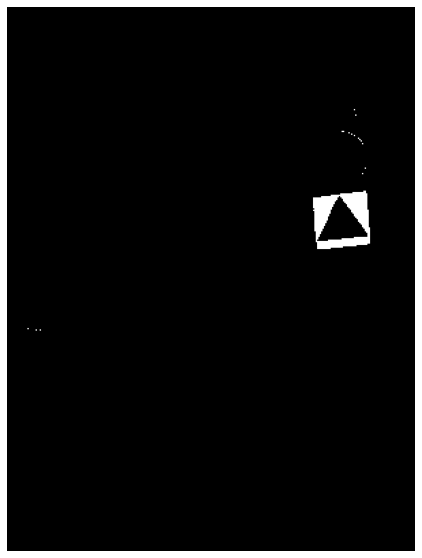

RED:


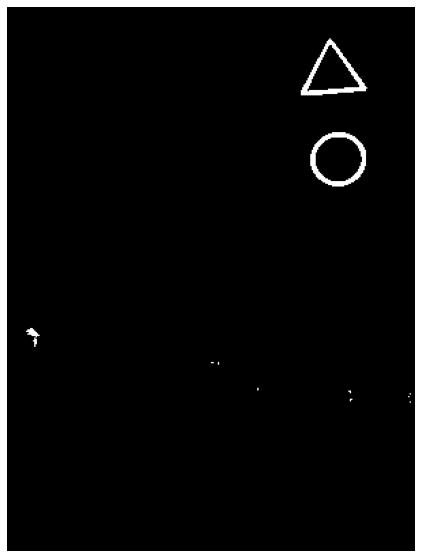

In [11]:
def regionGrow(hs):

    points = []
    hs_r = hs.copy()
    for i in range(0, hs.shape[0], 16):
        for j in range(0, hs.shape[1], 16):
            window = hs[i:i+16, j:j+16]
            whiteCnt = np.sum(window == 255)
            if whiteCnt >= 60:
                stop = False
                for k in range(1, window.shape[0] - 1):
                    for l in range(1, window.shape[1] - 1):
                        if window[k, l] == 255:
                            # hs[i + k, j + l] = 10
                            points.append((i + k, j + l))
                            break
                    else:
                        break

    for point in points:
        if hs_r[point] == 254: # Ignore points that were already filled
            continue
        _, hs_r, m, r = cv.floodFill(hs_r, None, (point[1], point[0]), 254, 17, 15)

    ret, hs_r = cv.threshold(hs_r, 253, 256, cv.THRESH_BINARY)
    return hs_r

def splitImage(img):
    hs_red = splitColorShadowHighlightInv(img, RED)
    hs_blue = splitColorShadowHighlightInv(img, BLUE)

    hs_red = regionGrow(hs_red)
    hs_blue = regionGrow(hs_blue)

    return hs_blue, hs_red


b, r = splitImage(img)

print("BLUE:")
displayImage(b)

print("RED:")
displayImage(r)

## Bounding Boxes - Detecting ROI
Find areas of the image that have a high chance of containing a traffic.
For this we find edges, apply contour drawing and filter contours out. The remainig contours are considered possible ROI

### Draw Edges

Apply gaussian blur, then adaptive treshold

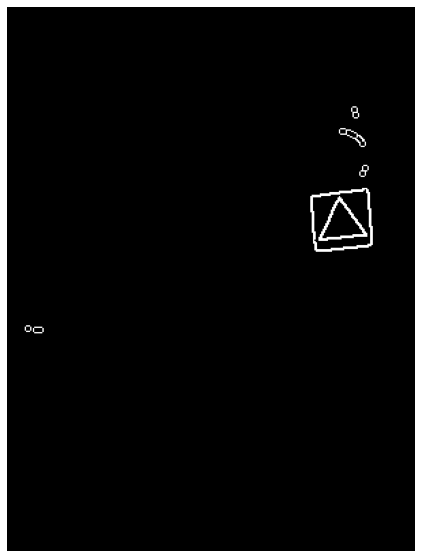

In [12]:
def getEdges(img):
    #img = cv.blur(img, (5, 5))
    img = cv.GaussianBlur(img.copy(), (3, 3), 1)
    #img = cv.morphologyEx(img, cv.MORPH_CLOSE, (5, 5), iterations=3)
    img = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 3, 2)
    #img = cv.Canny(img, 10, 200)
    # Canny + Morph close were tinkered with, but they didn't work as well (started merging ROI of two signs)
    return img

channel = hs_blue

hs_edges = getEdges(channel.copy())
displayImage(hs_edges)

Draw contours and filter them out. Draw a bounding rectangle for each one.

#### Draw Contours and find bounding rectangles

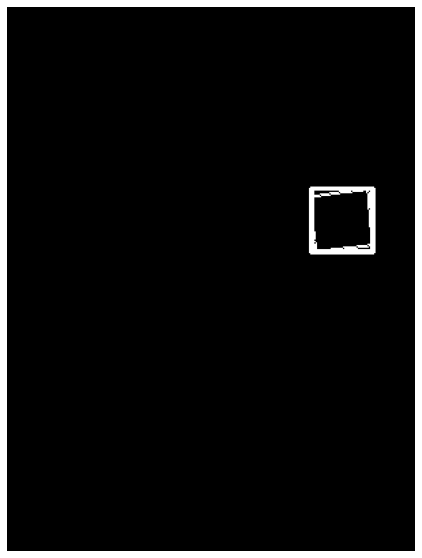

In [13]:
def getAllCountours(img):
    # Returns list of filtered countours => tuple(countour and its bounding rectangle)
    MIN_SIZE = 10
    MIN_COUNT_RECT_RATIO = 0.5
    MIN_ASPECT_RATIO = 0.4

    #ret, thresh = cv.threshold(img,127,255,0)
    #thresh = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)
    contours, hierarchy = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

    countours_rects = []
    for i in range(len(contours)):
        cnt = contours[i]
        x,y,w,h = cv.boundingRect(cnt)
        rect = (x, y, w, h)
        # Rect has a minimum size
        if (w < MIN_SIZE or h < MIN_SIZE):
            continue
        # Contour needs to be closed
        contourArea = cv.contourArea(cnt)
        if contourArea <= cv.arcLength(cnt, True):
            continue
        # Percentage contour area needs to be higher than threshold
        contourAreaPerc = contourArea / (w * h)
        if contourAreaPerc <= MIN_COUNT_RECT_RATIO:
            continue
        aspect_ratio = min(w, h) / max(w, h)
        # Aspect ratio needs to be higher than threshold
        if aspect_ratio <= MIN_ASPECT_RATIO:
            continue
        
        countours_rects.append((cnt, rect))
    return countours_rects

#drawing = hs_edges.copy()
drawing = np.zeros((hs_edges.shape[0], hs_edges.shape[1], 1), np.uint8)
countours = getAllCountours(hs_edges.copy())
for cnt, (x, y, w, h) in countours:
    cv.drawContours(drawing, [cnt], 0, 500)
    cv.rectangle(drawing, (x,y), (x + w, y + h), 255, 2)

displayImage(drawing)

Filter out rectangles that are contained inside other rectangles

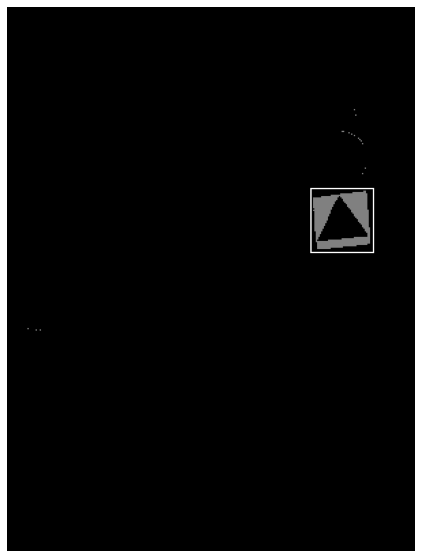

In [14]:
def filterCountours(candidate_countours):
    def isInsideRects(rect, rects):
        def isInside(r1, r2):
            (r1_x1, r1_y1, r1_w, r1_h) = r1
            r1_x2, r1_y2 = r1_x1 + r1_w, r1_y1 + r1_h
            (r2_x1, r2_y1, r2_w, r2_h) = r2
            r2_x2, r2_y2 = r2_x1 + r2_w, r2_y1 + r2_h

            point_dist = lambda x1, y1, x2, y2: np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            p1_d = point_dist(r1_x1, r1_y1, r2_x1, r2_y1)
            p2_d = point_dist(r1_x2, r1_y2, r2_x2, r2_y2)

            return r1_x1 < r2_x1 < r2_x2 < r1_x2 and r1_y1 < r2_y1 < r2_y2 < r1_y2\
                or max(p1_d, p2_d) <= 5 # Are reasonably close
        for r in rects:
            if isInside(r, rect):
                return True
        return False

    # Process bigger area rectanles first
    candidate_countours.sort(key=lambda x: x[1][2] * x[1][3], reverse=True)
    countours, rects = [], []
    for cnt, rect in candidate_countours:
        if not isInsideRects(rect, rects):
            countours.append((cnt, rect))
            rects.append(rect)

    return countours

countours = filterCountours(countours)
drawing = channel.copy()
drawing = drawing / 2
i = 0
for cnt, (x, y, w, h) in countours:
    i += 1
    cv.rectangle(drawing, (x, y), (x + w, y + h), 255, 1)


displayImage(drawing)

## Shape Detection

We need to classify the shape of the signal or discard the region as not a signal if no shapes are found.
This function takes a roi and returns if the shape is a triangle, rectangle, octagon or circle.

In [15]:
def addPadding(rect, img, padding):
    # Adds padding to a rect bounding box so that corner and shape detection can be more accurate
    w, h = rect[2], rect[3]
    y1 = max(0, round(rect[1] - h * padding))
    y2 = min(img.shape[0], round(rect[1] + h + h * padding))
    x1 = max(0, round(rect[0] - w * padding))
    x2 = min(img.shape[1], round(rect[0] + w + w * padding))

    return img[y1:y2, x1:x2]

def shapeDetection(roi):
    #roi = cv.Canny(roi.copy(), 10, 200)
    # roi = cv.adaptiveThreshold(roi.copy(),255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY_INV,3,2)
    # displayImage(roi)
    # roi = cv.GaussianBlur(roi,(9,9),1)
    _,roi = cv.threshold(roi,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    kernel = np.ones((3))
    roi = cv.dilate(roi.copy(), kernel, iterations=2)
    # displayImage(roi)

    cnts = getAllCountours(roi)
    cnts = filterCountours(cnts)
    if len(cnts) == 0:
        return "unidentified"

    c = cnts[0][0] # Get the first filtered contour
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.04 * peri, True)

    # displayImage(roi)
    if len(approx) == 3:
        return "triangle"
    elif len(approx) == 4:
        return "rectangle"

    hull = cv.convexHull(c)
    peri = cv.arcLength(hull, True)
    area = cv.contourArea(hull)
    approx_circle = cv.approxPolyDP(hull, 0.013 * peri, True)
    circularity = (4 * np.pi * area) / (peri ** 2)
    # print("Circ: " + str(circularity) + " " + str(len(approx_circle)))

    if circularity < 0.7:
        return "unindentified"

    if circularity < 0.96:
        return "octogon"

    return "circle"


rect = countours[0][1]
roi = addPadding(rect, channel.copy(), 0.15)
shapeDetection(roi)

'rectangle'

To identified upside down triangles from normal triangles, we perform harris corner detection and use the corners to calculate score for each shape

### Harris Corner Detection

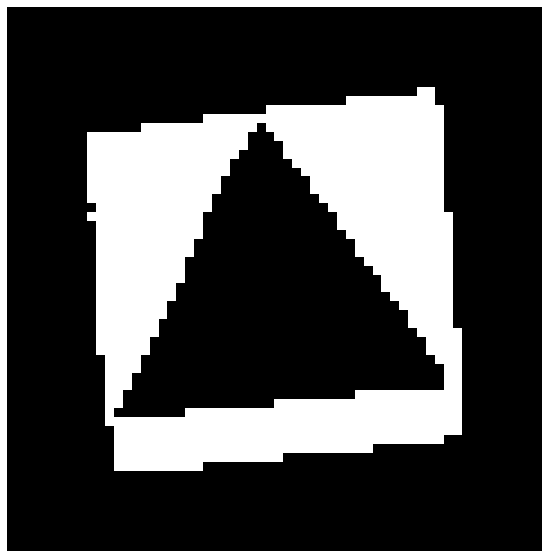

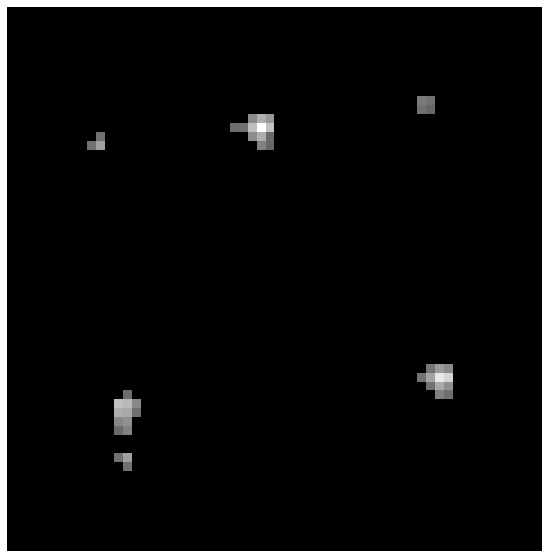

In [16]:
def getCorners(roi):
    neighbourhood = max(roi.shape[0], roi.shape[1]) // 32
    aperture = 1
    free_param = 0.07
    harris = cv.cornerHarris(roi.copy(), 5, 3, 0.05)
    threshold = 0.4

    harris[harris < threshold * harris.max()] = 0
    return harris

#blur = cv.blur(r.copy(),(5,5))
roi = addPadding(rect, channel.copy(), 0.15)
corners = getCorners(roi.copy())
displayImage(roi)
displayImage(corners)

### Score calculation
Using the corners, we split the roi into regions and check if a corner is inside each region.
Based on each region score, we calculate the probability that the roi is a square, triangle_up and triangle_down

In [17]:
def cornerIdentification(corners):
    corners = corners.copy()
    w, h= corners.shape[0], corners.shape[1]
    # Identify areas of interest inside the roi
    ratio = 1 / 8
    x_tick = round(h * ratio)
    y_tick = round(w * ratio)
    tl_range = slice(0, 3 * y_tick + 1), slice(0, 3 * x_tick + 1)
    tr_range = slice(0, 3 * y_tick + 1), slice(5 * x_tick, h)
    bl_range = slice(5 * y_tick, w + 1), slice(0, 3 * x_tick + 1)
    br_range = slice(5 * y_tick, w + 1), slice(5 * x_tick, h)

    tc_range = slice(0, 3 * y_tick + 1), slice(3 * x_tick, 5 * x_tick + 1)
    bc_range = slice(5 * y_tick, w + 1), slice(3 * x_tick, 5 * x_tick + 1)

    # Assign values if corners are found inside them
    # displayImage(corners)
    tl, tr, bl, br = 0, 0, 0, 0
    if np.any(corners[tl_range]): tl = 0.25
    if np.any(corners[tr_range]): tr = 0.25
    if np.any(corners[bl_range]): bl = 0.25
    if np.any(corners[br_range]): br = 0.25

    tc, bc = 0, 0
    if np.any(corners[tc_range]): tc = 0.34
    if np.any(corners[bc_range]): bc = 0.34

    square = tl + tr + bl + br
    triangle_up = 1.32 * (bl + br) + tc - 1.1 * (tl + tr)
    triangle_down = 1.32 * (tl + tr) + bc - 1.1 * (bl + br)

    # print(square, triangle_up, triangle_down)
    return square, triangle_up, triangle_down

    
cornerIdentification(corners)

(1.0, 0.44999999999999996, 0.10999999999999999)

### Circle Detection

This is the old circle detection method, used before the circularity measure. It is based on the FRS method. It doesn't perform very well. 

In [18]:
MIN_RADIUS = 30
def circleIdentificationFRS(roi):
    import frs
    r_w, r_h = roi.shape[0], roi.shape[1]

    frs_res = frs.frst(roi, max(r_w, r_h) // 2, 2, 0, max(r_w, r_h) / 4, "BRIGHT")
    w, h = frs_res.shape[0], frs_res.shape[1]
    dim = max(w, h)
    tick = 1 / 5
    region = slice(round(2 * tick * dim), round(3 * tick * dim)), slice(round(2 * tick * dim), round(3 * tick * dim))

    m = frs_res[region].max()
    avg = np.average(frs_res[region])
    # print("M: ", m, "AVG: ", avg, avg / m)
    # print(frs_res[region])
    #displayImage(frs_res[region])
    #displayImage(frs_res)
    cp = avg / m
    return cp


def circleIdentification(roi): # Octogono => 92% area of circle
    ret, thresh = cv.threshold(roi.copy(),100,200,0)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) # TODO
    if (len(contours) == 0):
        return 0

    # for cnt in contours:
        # cv.drawContours(roi, [cnt], 0, 500)
    # displayImage(roi)

    cnt = contours[0]
    (x, y), r = cv.minEnclosingCircle(cnt)
    area_circle = np.pi * r ** 2
    contourArea = cv.contourArea(cnt)

    return contourArea / area_circle

rect = countours[0][1]
# blur = cv.blur(r.copy(),(5,5))
roi = addPadding(rect, channel.copy(), 0.15)
# circleIdentification(roi)

circleIdentification(roi)

0.6276697089742889

## Shape detection
Now we want to analyse the contours for the red and blue channels, use shape detection to determine the shape, and classify the ROI based on the shape and color of the ROI.

In [19]:
COLOR_THRESHOLD = 0.5
SHAPE_THRESHOLD = 0.4
CIRCLE_THRESHOLD = 0.9

# from enum import Enum
# class Sign(Enum):
#     STOP = 1
#     INFORMATION = 2
#     SPEEDLIMIT = 3
#     WARNING = 4
#     PRIORITY = 5


def classifyContours(b, r, cnts_b, cnts_r, printProbs=False):
    def classifyRed(r, rect, c, printProbs=False):
        red = addPadding(rect, r, 0.15)
        corners_r = getCorners(red)
        sq_r, t_up_r, t_down_r = cornerIdentification(corners_r)
        circle_r = circleIdentification(red)
        shape_max = max(sq_r, t_up_r, t_down_r, circle_r)
        red_pred = shapeDetection(red)
        if printProbs:
            print("Red is " + red_pred + " - Square: ", sq_r, " TriUp: ", t_up_r, " TriDown: ", t_down_r, " Circle: ", circle_r)
            #displayImage(red)

        if red_pred == "triangle" or\
            (red_pred == "unidentified" and (shape_max == t_down_r or shape_max == t_up_r)):

            if (t_up_r > t_down_r):
                return "danger"
            else:
                return "yield"
        if red_pred == "circle" or\
            (red_pred == "unidentified" and shape_max == circle_r):
            return "speedlimit"
        
        if red_pred == "octogon":
            return "stop"

        return "unidentified"

    def classifyBlue(b, rect, c, printProbs=False):
        blue = addPadding(rect, b, 0.15)
        corners_b = getCorners(blue)
        sq_b, t_up_b, t_down_b = cornerIdentification(corners_b)
        circle_b = circleIdentification(blue)
        shape_max = max(sq_b, t_up_b, t_down_b, circle_b)
        blue_pred = shapeDetection(blue)

        if printProbs:
            # displayImage(blue), displayImage(red)
            # print("Scored blue: " + str(blue_score) + " red: " + str(red_score))
            print("Blue is " + blue_pred + " - Square: ", sq_b, " TriUp: ", t_up_b, " TriDown: ", t_down_b, " Circle: ", circle_b)

        if shape_max < SHAPE_THRESHOLD and blue_pred == "unidentified":
            return "unidentified"
            # displayImage(blue)
        if blue_pred == "rectangle" or\
            (blue_pred == "unidentified" and shape_max == sq_b):
            return "crosswalk"
        if blue_pred == "circle" or\
            (blue_pred == "unidentified" and shape_max == circle_b):
            return "mandatory"

        return "unidentified"

    ret = []
    for cnt, rect in cnts_b:
        sign_class = classifyBlue(b, rect, cnt, printProbs)
        if sign_class != "trash":
            ret.append(sign_class)
    for cnt, rect in cnts_r:
        sign_class = classifyRed(r, rect, cnt, printProbs)
        if sign_class != "trash":
            ret.append(sign_class)

    return ret

cnts_b = filterCountours(getAllCountours(hs_blue))
cnts_r = filterCountours(getAllCountours(hs_red))
classifyContours(hs_blue, hs_red, cnts_b, cnts_r, True)

Blue is rectangle - Square:  1.0  TriUp:  0.44999999999999996  TriDown:  0.10999999999999999  Circle:  0.6276697089742889
Red is triangle - Square:  0.5  TriUp:  1.0  TriDown:  -0.55  Circle:  0.45613466452519363
Red is circle - Square:  0.5  TriUp:  0.66  TriDown:  -0.55  Circle:  0.9187424020792477


['crosswalk', 'danger', 'speedlimit']

## Create Pipeline
 Create a function that will be used to test with the entire dataset

In [20]:
def classifyImage(img):
    # displayImage(img)
    img = applyCLAHE(img)
    img = meanShift(img)
    b, r = splitImage(img)
    def getContours(c):
        hs_edges = getEdges(c)
        countours = getAllCountours(hs_edges)
        countours = filterCountours(countours)
        return countours
    predicts = classifyContours(b, r, getContours(b), getContours(r))
    return predicts

img = importImageDataset(filterType(["stop"]).index[8])  # Classify the eigth stop image
# To import a custom image, place the image into the dataset/images folder and uncomment the line bellow
# img = importImage("image_name.png")
classifyImage(img)

['stop']

To import a custom image (the image must be in `dataset/images/`) and classify it, do as follows:

In [21]:
img = importImage("road0.png")
classifyImage(img)

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


## Evaluation

In [ ]:
sign_types = ["speedlimit", "crosswalk", "stop"]
sign_accs = [sign_t + "_acc" for sign_t in sign_types]
df = pd.DataFrame(columns = [sign_accs + ["recall", "predicted", "expected"]])
# This function takes the predicted signs and expected signs and calculates the accuracy for each sign type and recall
def accuracy(predictions, expected):
    def createDictCount(x):
        return {item:x.count(item) for item in x}

    preds_d = createDictCount(predictions)
    expected_d = createDictCount(expected)
    hits, guesses = 0, 0
    accs = []
    for t in sign_types:
        if t in expected_d:
            if t in preds_d: # Put accuracy
                accs.append(min(preds_d[t], expected_d[t]) / expected_d[t])
                hits += min(preds_d[t], expected_d[t])
                guesses += preds_d[t]
            else: # No prediction => Accuracy 0
                accs.append(0)
        else: # No type expected
            accs.append(None)

    recall = hits / guesses if guesses != 0 else 0
    return preds_d, expected_d, recall, accs

# These are signs that fall within the categories: good quality images, low saturation, and shifted color range
good = [52, 137, 152, 134, 94, 516, 121, 57, 68]
baixa_sat = [637, 715, 411, 390, 317, 303, 382, 337, 335, 74]
shifted = [22, 135, 453, 349, 558, 106]

##for index, x in tmp.iterrows():
i = 0
for index, x in signs.iterrows():
    #x = signs.loc[i]
    expected = list(filter(lambda x: "trafficlight" not in x, x["type"]))
    if len(expected) == 0: # Ignore images that contain traffic lights
        continue

    #if i == 15:
        #break
    i += 1
    image = importImageDataset(index)
    predicts = classifyImage(image)
    print(predicts)
    preds_d, expect_d, recall, accs = accuracy(predicts, expected)
    df.loc[i] = accs + [recall, preds_d, expect_d]

df

Parsing: 22
['stop', 'stop', 'yield', 'unidentified', 'unidentified', 'stop', 'yield', 'unidentified', 'yield', 'unidentified']
Parsing: 52
['crosswalk', 'stop']
Parsing: 53
['speedlimit', 'stop', 'stop', 'unidentified', 'unidentified', 'stop', 'stop', 'stop', 'stop', 'stop', 'stop', 'stop']
Parsing: 54
['unidentified', 'crosswalk', 'crosswalk', 'unidentified', 'stop', 'stop']
Parsing: 55
['unidentified', 'unidentified']
Parsing: 56
['stop', 'stop']
Parsing: 57
['crosswalk', 'unidentified', 'stop', 'unidentified']
Parsing: 58
['crosswalk', 'crosswalk', 'crosswalk', 'crosswalk', 'crosswalk', 'stop']
Parsing: 59
['stop']
Parsing: 60
['crosswalk', 'mandatory', 'crosswalk', 'unidentified', 'crosswalk', 'unidentified', 'unidentified', 'unidentified', 'crosswalk', 'unidentified', 'crosswalk', 'crosswalk', 'crosswalk', 'crosswalk', 'unidentified', 'unidentified', 'unidentified', 'mandatory', 'mandatory', 'stop']
Parsing: 61
['stop']
Parsing: 62
['speedlimit', 'unidentified', 'stop', 'yield', 

,speedlimit_acc,crosswalk_acc,stop_acc,recall,predicted,expected
1,None,None,1.0,0.333333,"{'stop': 3, 'yield': 3, 'unidentified': 4}",{'stop': 1}
2,None,None,1.0,1.000000,"{'crosswalk': 1, 'stop': 1}",{'stop': 1}
3,None,None,1.0,0.111111,"{'speedlimit': 1, 'stop': 9, 'unidentified': 2}",{'stop': 1}
4,None,None,1.0,0.500000,"{'unidentified': 2, 'crosswalk': 2, 'stop': 2}",{'stop': 1}
5,None,None,0.0,0.000000,{'unidentified': 2},{'stop': 1}
...,...,...,...,...,...,...
820,0,None,1.0,1.000000,"{'crosswalk': 7, 'unidentified': 11, 'stop': 1...","{'speedlimit': 1, 'stop': 1}"
821,0,None,1.0,1.000000,"{'crosswalk': 8, 'unidentified': 3, 'stop': 1,...","{'speedlimit': 2, 'stop': 1}"
822,0,None,1.0,1.000000,"{'crosswalk': 5, 'unidentified': 6, 'stop': 1,...","{'speedlimit': 2, 'stop': 1}"
823,0.5,None,1.0,1.000000,"{'crosswalk': 6, 'unidentified': 7, 'speedlimi...","{'speedlimit': 2, 'stop': 1}"


Export results

In [ ]:
df.to_csv("results.csv")
#df = pd.read_csv("results.csv")
# df

Calculate average accuracy for each sign type and recall

In [ ]:
df["stop_acc"].mean(), df["crosswalk_acc"].mean(), df["speedlimit_acc"].mean(), df["recall"].mean()

(stop_acc    0.725275
 dtype: float64,
 crosswalk_acc    0.870098
 dtype: float64,
 speedlimit_acc    0.406342
 dtype: float64,
 recall    0.443412
 dtype: float64)